In [6]:
import os
os.chdir(r"c:\Users\rohan\Documents\Flutter Projects\saas-subscription-analytics")
os.getcwd()

'c:\\Users\\rohan\\Documents\\Flutter Projects\\saas-subscription-analytics'

In [7]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

con = duckdb.connect("saas.db")


In [8]:
accounts = con.execute("SELECT * FROM accounts_clean").df()
subscriptions = con.execute("SELECT * FROM subscriptions_clean").df()
churn = con.execute("SELECT * FROM churn_events_clean").df()
usage = con.execute("SELECT * FROM feature_usage_clean").df()
tickets = con.execute("SELECT * FROM support_tickets_clean").df()


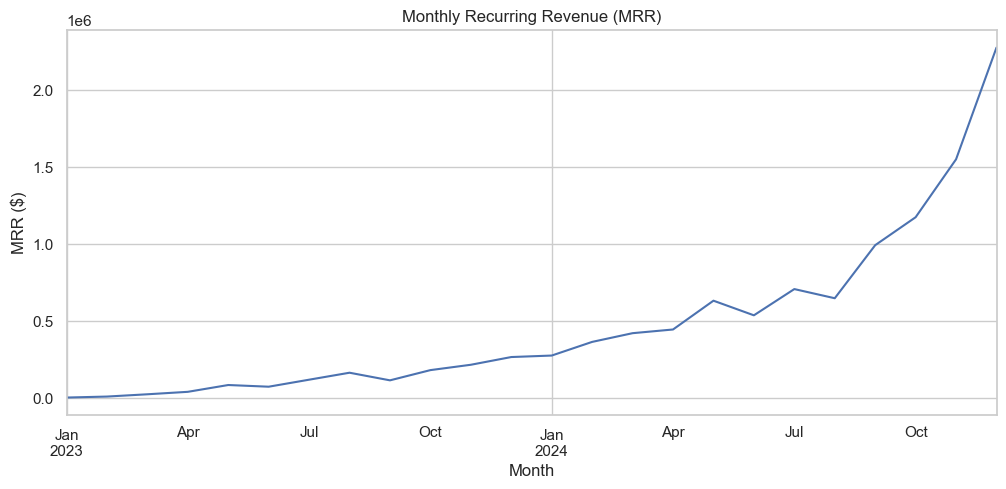

In [9]:
subscriptions["start_month"] = (
    pd.to_datetime(subscriptions["start_date"])
    .dt.to_period("M")
    .dt.to_timestamp()
)

mrr_trend = subscriptions.groupby("start_month")["mrr_amount"].sum()

plt.figure(figsize=(12,5))
mrr_trend.plot()
plt.title("Monthly Recurring Revenue (MRR)")
plt.ylabel("MRR ($)")
plt.xlabel("Month")
plt.show()


In [10]:
# ==============================
# Build cohort pivots for plots
# ==============================

# Cohort month
accounts["cohort_month"] = (
    pd.to_datetime(accounts["signup_date"])
    .dt.to_period("M")
    .dt.to_timestamp()
)

# ------------------------------
# Retention pivot
# ------------------------------
subscriptions["active_month"] = (
    pd.to_datetime(subscriptions["start_date"])
    .dt.to_period("M")
    .dt.to_timestamp()
)

retention_df = subscriptions.merge(
    accounts[["account_id", "cohort_month"]],
    on="account_id",
    how="left"
)

retention = (
    retention_df
    .groupby(["cohort_month", "active_month"])["account_id"]
    .nunique()
    .reset_index(name="active_users")
)

cohort_sizes = (
    accounts.groupby("cohort_month")["account_id"]
    .nunique()
    .reset_index(name="cohort_users")
)

retention = retention.merge(cohort_sizes, on="cohort_month")
retention["retention_rate"] = retention["active_users"] / retention["cohort_users"]

retention_pivot = retention.pivot(
    index="cohort_month",
    columns="active_month",
    values="retention_rate"
)

# ------------------------------
# Adoption pivot
# ------------------------------
usage["usage_month"] = (
    pd.to_datetime(usage["usage_date"])
    .dt.to_period("M")
    .dt.to_timestamp()
)

usage_df = usage.merge(
    subscriptions[["subscription_id", "account_id"]],
    on="subscription_id",
    how="left"
).merge(
    accounts[["account_id", "cohort_month"]],
    on="account_id",
    how="left"
)

adoption = (
    usage_df
    .groupby(["cohort_month", "usage_month"])["account_id"]
    .nunique()
    .reset_index(name="active_users")
)

adoption = adoption.merge(cohort_sizes, on="cohort_month")
adoption["adoption_rate"] = adoption["active_users"] / adoption["cohort_users"]

adoption_pivot = adoption.pivot(
    index="cohort_month",
    columns="usage_month",
    values="adoption_rate"
)

# ------------------------------
# Churn pivot
# ------------------------------
churn["churn_month"] = (
    pd.to_datetime(churn["churn_date"])
    .dt.to_period("M")
    .dt.to_timestamp()
)

churn_df = churn.merge(
    accounts[["account_id", "cohort_month"]],
    on="account_id",
    how="left"
)

churn_rates = (
    churn_df
    .groupby(["cohort_month", "churn_month"])["account_id"]
    .nunique()
    .reset_index(name="churned_users")
)

churn_rates = churn_rates.merge(cohort_sizes, on="cohort_month")
churn_rates["churn_rate"] = churn_rates["churned_users"] / churn_rates["cohort_users"]

churn_pivot = churn_rates.pivot(
    index="cohort_month",
    columns="churn_month",
    values="churn_rate"
)


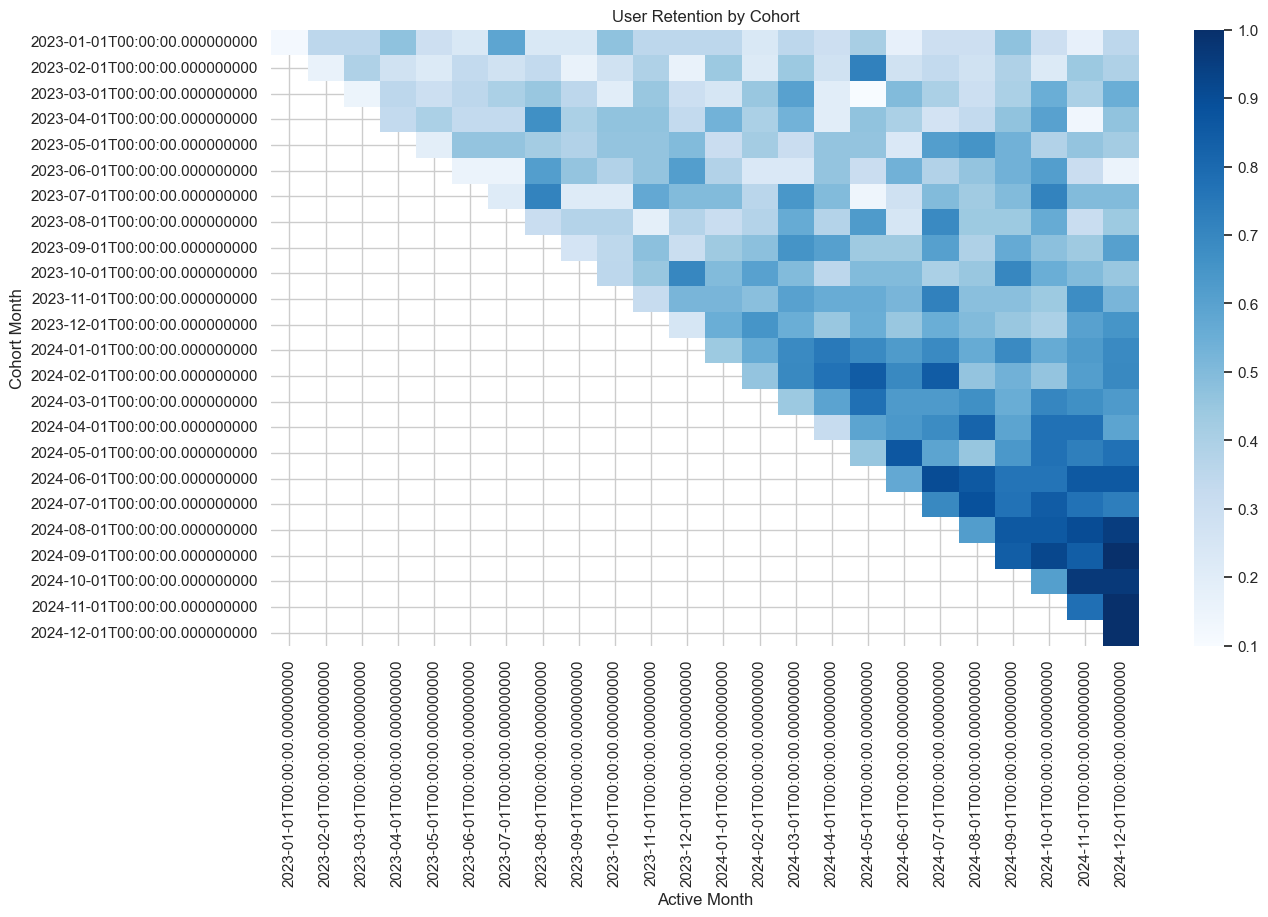

In [11]:
plt.figure(figsize=(14,8))
sns.heatmap(retention_pivot, cmap="Blues")
plt.title("User Retention by Cohort")
plt.xlabel("Active Month")
plt.ylabel("Cohort Month")
plt.show()


newer cohorts have a higher short-term retenion compared to earlier cohorts


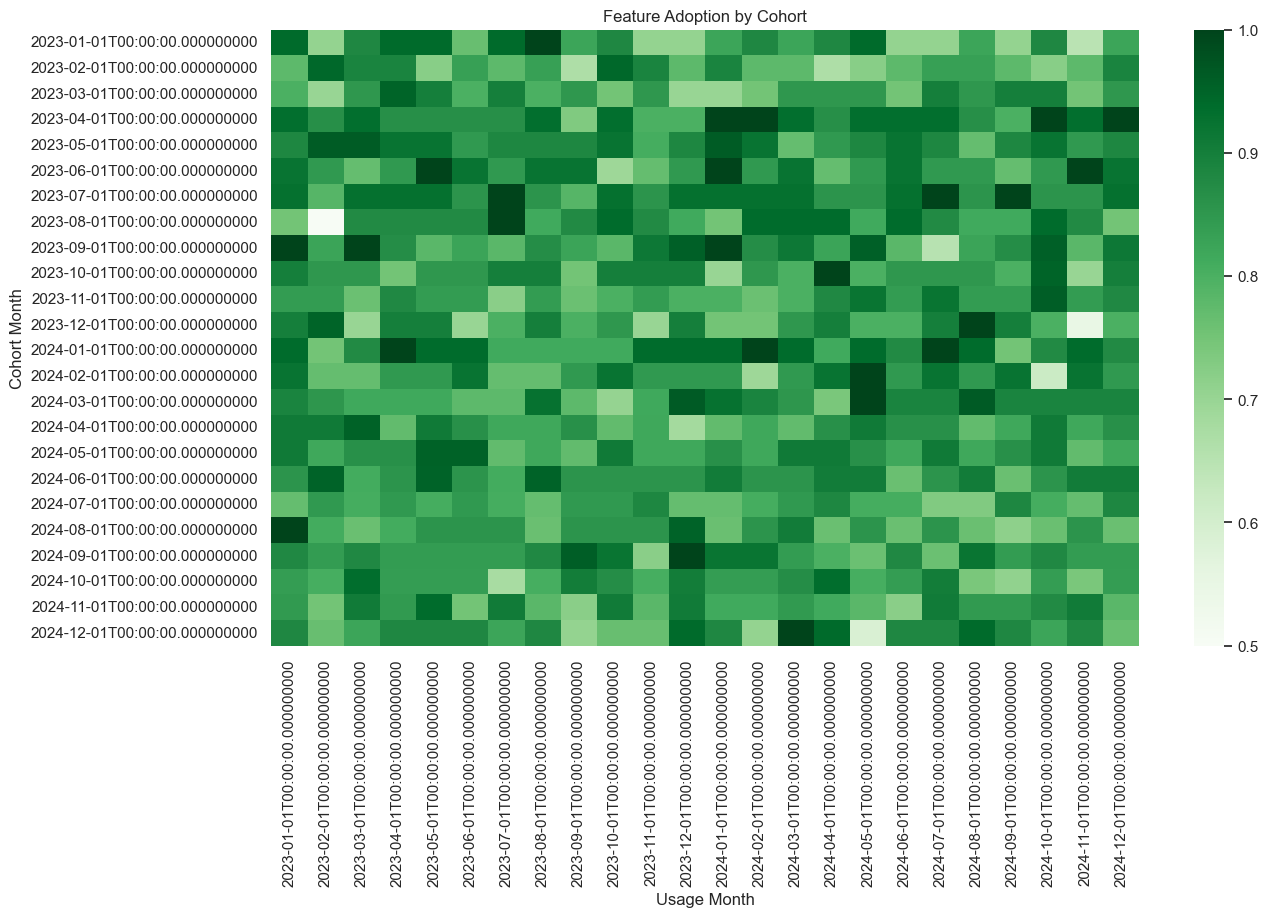

In [12]:
plt.figure(figsize=(14,8))
sns.heatmap(adoption_pivot, cmap="Greens")
plt.title("Feature Adoption by Cohort")
plt.xlabel("Usage Month")
plt.ylabel("Cohort Month")
plt.show()


feature adoption is consistently high accross cohorts, which shows that moderate retention is due to value-perception, not a usability problem.

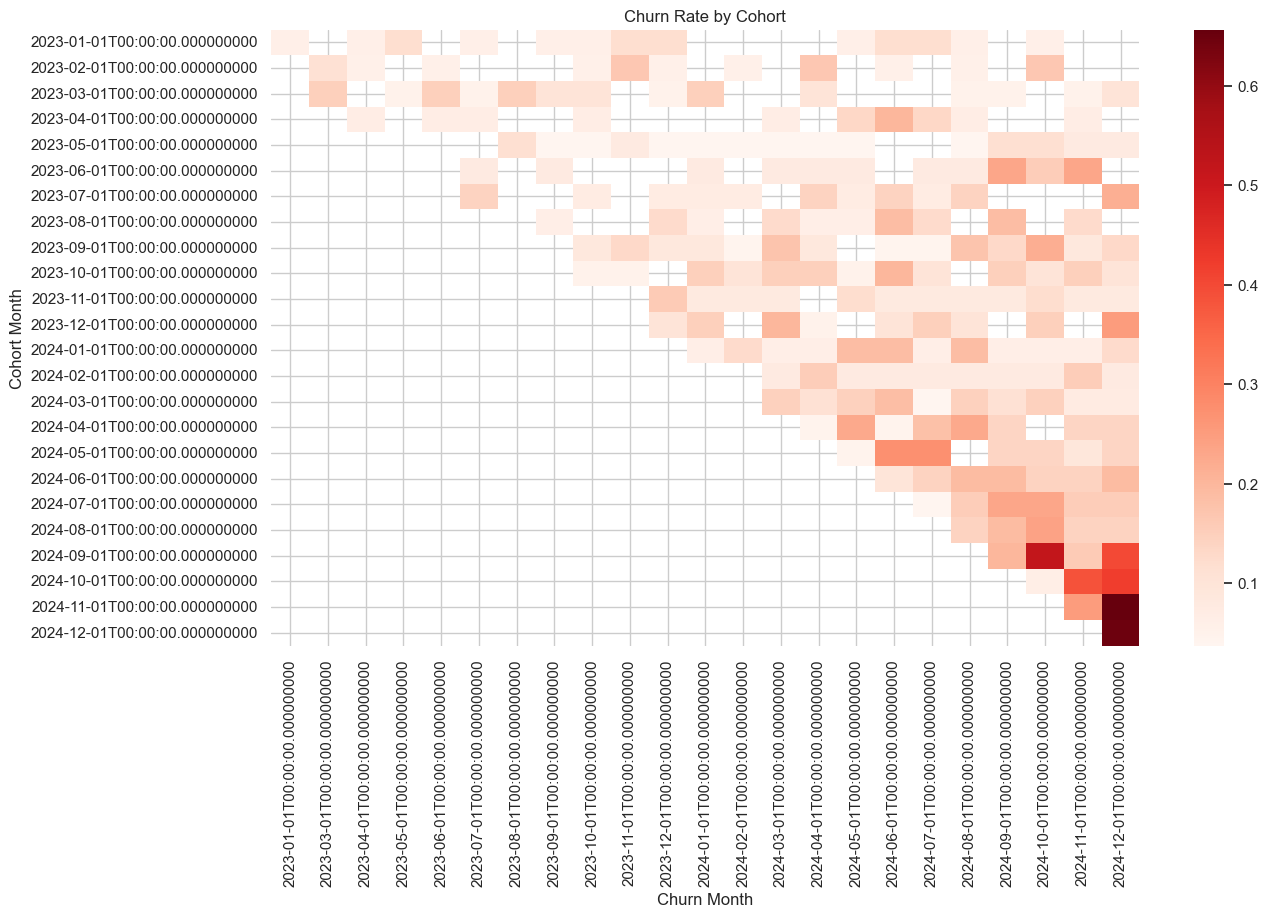

In [13]:
plt.figure(figsize=(14,8))
sns.heatmap(churn_pivot, cmap="Reds")
plt.title("Churn Rate by Cohort")
plt.xlabel("Churn Month")
plt.ylabel("Cohort Month")
plt.show()


churn is delayed, which means that customers understand the product but later decide it's not worth paying for

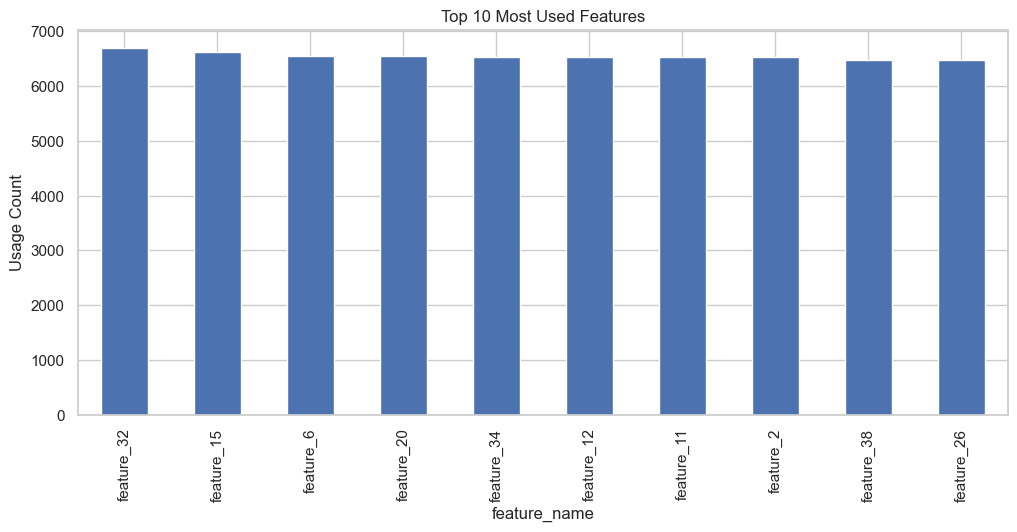

In [14]:
top_features = (
    usage.groupby("feature_name")["usage_count"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(12,5))
top_features.plot(kind="bar")
plt.title("Top 10 Most Used Features")
plt.ylabel("Usage Count")
plt.show()


high feature usage, retention should be improved by focusing on packaging, pricing, and positioning not discoveribility

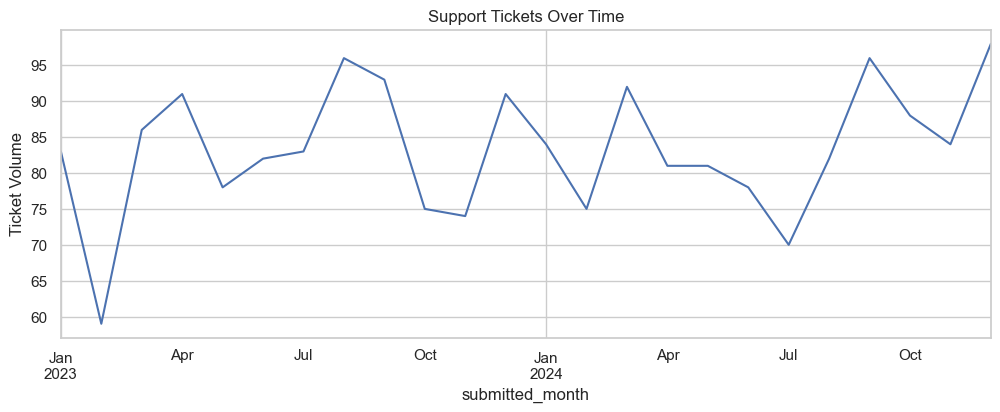

In [15]:
tickets["submitted_month"] = (
    pd.to_datetime(tickets["submitted_at"])
    .dt.to_period("M")
    .dt.to_timestamp()
)

tickets_per_month = tickets.groupby("submitted_month").size()

plt.figure(figsize=(12,4))
tickets_per_month.plot()
plt.title("Support Tickets Over Time")
plt.ylabel("Ticket Volume")
plt.show()


support tickets are consistent not significantly increasing with the increase of the user base. deeper analysis to see link between tickets and churn. Also to see if tickets are coming from users with high feature usage or new vs older cohorts

In [16]:
tickets["resolution_time_hours"].describe()


count    2000.000000
mean       35.861000
std        21.138427
min         1.000000
25%        17.000000
50%        35.000000
75%        54.000000
max        72.000000
Name: resolution_time_hours, dtype: float64